In [11]:
import sys
import itertools
from pathlib import Path
from typing import Dict, List
src_path = Path("../src/dt-distance").resolve()
data_path = Path("../data").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
sys.path.append(str(data_path))

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from dt_distance.data_processor import DataProcessor
from dt_distance.tree_parser import TreeParser
from dt_distance.distance_calculator import DistanceCalculator
from dt_distance.problem_params import ProblemParams
import matplotlib.pyplot as plt

# set seed for reproducibility
np.random.seed(42)

DEPTHS = list(range(3, 13))
MIN_SAMPLES = [3, 5, 10, 30, 50]

NUM_BOOTSTRAPS = 50
DATA_PATH = "../data/DataSet_Combined_SI_SNI_Baseline_FE.csv"

FEATURE_SETS: Dict[str, List[str]] = {
    "suicidea": [
        "age", "gender", "sexori", "raceall", "trauma_sum", "cesd_score", "harddrug_life", "school", "degree", "job", "sex", "concurrent", "exchange", "children", "weapon", "fight", "fighthurt", "ipv", "ptsd_score", "alcfirst", "potfirst", "staycurrent", "homelage", "time_homeless_month", "jail", "jailkid", "gettherapy", "sum_alter", "sum_family", "sum_home_friends", "sum_street_friends", "sum_unknown_alter", "sum_talk_once_week", "sum_alter3close", "prop_family_harddrug", "prop_friends_harddrug", "prop_friends_home_harddrug", "prop_friends_street_harddrug", "prop_alter_all_harddrug", "prop_enc_badbehave", "prop_alter_homeless", "prop_family_emosup", "prop_friends_emosup", "prop_friends_home_emosup", "prop_friends_street_emosup", "prop_alter_all_emosup", "prop_family_othersupport", "prop_friends_othersupport", "prop_friends_home_othersupport", "prop_friends_street_othersupport", "prop_alter_all_othersupport", "sum_alter_staff", "prop_object_badbehave", "prop_enc_goodbehave", "prop_alter_school_job", "sum_alter_borrow"],
    "suicattempt": [
        "age", "gender", "sexori", "raceall", "trauma_sum", "cesd_score", "harddrug_life", "school", "degree", "job", "sex", "concurrent", "exchange", "children", "weapon", "fight", "fighthurt", "ipv", "ptsd_score", "alcfirst", "potfirst", "staycurrent", "homelage", "time_homeless_month", "jail", "jailkid", "gettherapy", "sum_alter", "prop_family", "prop_home_friends", "prop_street_friends", "prop_unknown_alter", "sum_talk_once_week", "sum_alter3close", "prop_family_harddrug", "prop_friends_harddrug", "prop_friends_home_harddrug", "prop_friends_street_harddrug", "prop_alter_all_harddrug", "prop_enc_badbehave", "prop_alter_homeless", "prop_family_emosup", "prop_friends_emosup", "prop_friends_home_emosup", "prop_friends_street_emosup", "prop_alter_all_emosup", "prop_family_othersupport", "prop_friends_othersupport", "prop_friends_home_othersupport", "prop_friends_street_othersupport", "prop_alter_all_othersupport", "sum_alter_staff", "prop_object_badbehave", "prop_enc_goodbehave", "prop_alter_school_job", "sum_alter_borrow"],
}

MODEL_PARAMS = {
    "suicidea": dict(min_samples_leaf=10, min_samples_split=20, max_depth=4),
    "suicattempt": dict(min_samples_leaf=10, min_samples_split=30, max_depth=4),
}

LABELS = ["suicidea", "suicattempt"]

## Import suicide dataset

In [13]:
def prepare_data(df: pd.DataFrame, features: List[str], label: str):
    df = df.replace('NaN', pd.NA)  # replace the string 'NaN' with actual NaN values
    df_full_cleaned = df[features + [label]].dropna().copy()
    X = df_full_cleaned[features]
    y = df_full_cleaned[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    X_full = df_full_cleaned[features]
    y_full = df_full_cleaned[label]
    return X_full, y_full, X_train, X_test, y_train, y_test

df = pd.read_csv(DATA_PATH)
X_full, y_full, X_train, X_test, y_train, y_test = prepare_data(df, FEATURE_SETS["suicidea"], "suicidea")

print(f"Number of samples in the full dataset: {len(X_full)}")
print(f"Number of samples in the training set: {len(X_train)}")
print(f"Number of samples in the test set: {len(X_test)}")
print(f"Shape of training set: {X_train.shape}")

Number of samples in the full dataset: 586
Number of samples in the training set: 439
Number of samples in the test set: 147
Shape of training set: (439, 56)


In [14]:
def random_train_split(X,y):
    N = X.shape[0]
    indices = np.random.permutation(N)
    X0, y0 = X[indices[:N // 2]], y[indices[:N // 2]]
    return X0, y0

X0, y0 = random_train_split(X_train.values, y_train.values)
X0.shape, y0.shape

((219, 56), (219,))

In [ ]:
def train_decision_tree(X, y, depth, min_samples_leaf):
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf)
    clf.fit(X, y)
    return clf

def bootstrap_trees(X, y, depths, min_samples, B):
    '''
    Create B bootstrap trees by sampling with replacement from X_0
    '''
    trees = []
    for _ in range(B):
        X_sample, y_sample = resample(X, y, replace= True)
        depth = np.random.choice(depths)
        min_leaf = np.random.choice(min_samples)
        tree = train_decision_tree(X_sample, y_sample, depth, min_leaf)
        trees.append(tree)
    return trees

T0 = bootstrap_trees(X0, y0, DEPTHS, MIN_SAMPLES, NUM_BOOTSTRAPS)
print("Number of trees in T0:", len(T0))

T = bootstrap_trees(X_train.values, y_train.values, DEPTHS, MIN_SAMPLES, NUM_BOOTSTRAPS)
print("Number of trees in T:", len(T))

Number of trees in T0: 50
Number of trees in T: 100


In [17]:
def compute_average_distances(T0, T, X_train, y_train):
    X_train_values = X_train.values if hasattr(X_train, 'values') else X_train
    
    distances = []
    for i, tree_b in enumerate(T):
        d_b = 0.0
        for tree_beta in T0:
            distance_calculator = DistanceCalculator(tree_beta, tree_b, X=X_train_values, y=y_train)
            d_b += distance_calculator.compute_tree_distance()
        d_b /= len(T0)
        distances.append(d_b)
    
    return distances
distances = compute_average_distances(T0, T, X_train, y_train)
print("Number of distances computed:", len(distances))

Number of distances computed: 100


In [18]:
def evaluate_predictive_power(trees, X_holdout, y_holdout):
    auc_scores = []
    for tree in trees:
        y_proba = tree.predict_proba(X_holdout)[:, 1]
        auc = roc_auc_score(y_holdout, y_proba)
        auc_scores.append(auc)
    return auc_scores

auc_scores = evaluate_predictive_power(T, X_test.values, y_test.values)
print("Average AUC score:", np.mean(auc_scores))

Average AUC score: 0.6152495232040687


In [19]:
def pareto_optimal_trees(distances, auc_scores):
    pareto_trees = []
    for i, (d_i, a_i) in enumerate(zip(distances, auc_scores)):
        dominated = False
        for j, (d_j, a_j) in enumerate(zip(distances, auc_scores)):
            if i != j and ((d_j <= d_i and a_j > a_i) or (d_j < d_i and a_j >= a_i)):
                dominated = True
                break
        if not dominated:
            pareto_trees.append(i)
    return pareto_trees

pareto_trees = pareto_optimal_trees(distances, auc_scores)
print("Number of Pareto optimal trees:", len(pareto_trees))

Number of Pareto optimal trees: 6


In [20]:
def select_final_tree(distances, auc_scores, pareto_indices, epsilon=0.01):
    best_auc = max(auc_scores)
    candidates = [i for i in pareto_indices if auc_scores[i] >= (1 - epsilon) * best_auc]
    if not candidates:
        candidates = pareto_indices
    best_idx = max(candidates, key=lambda i: auc_scores[i] - distances[i])
    return best_idx

selected_tree_index = select_final_tree(distances, auc_scores, pareto_trees)
print("Selected tree index:", selected_tree_index)

Selected tree index: 75


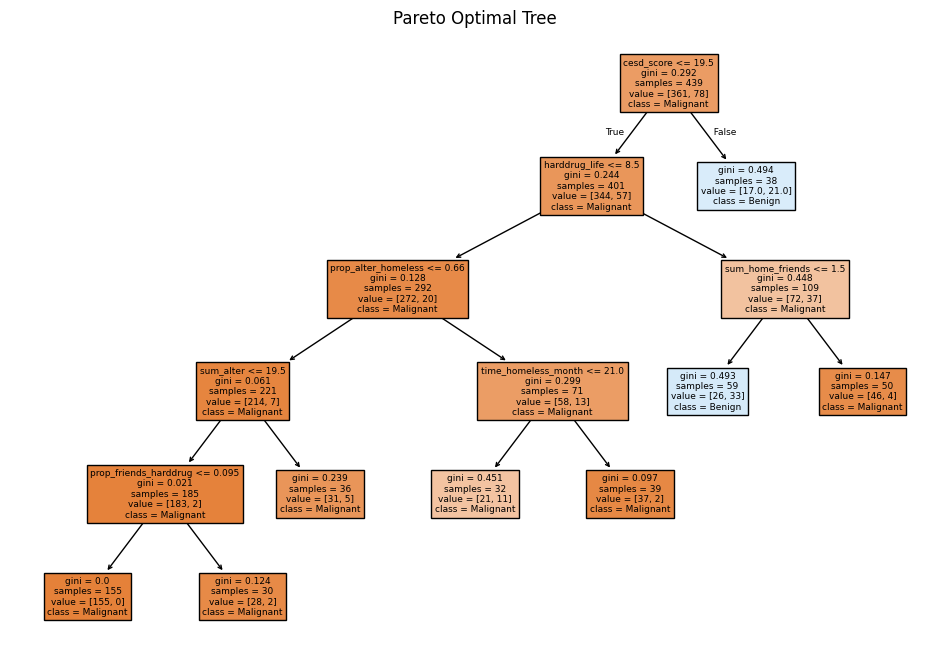

In [21]:
selected_tree = T[selected_tree_index]
plt.figure(figsize=(12, 8))
plot_tree(selected_tree, 
          feature_names=X_full.columns,
          class_names=["Malignant", "Benign"],
          filled=True)
plt.title("Pareto Optimal Tree")
plt.show()

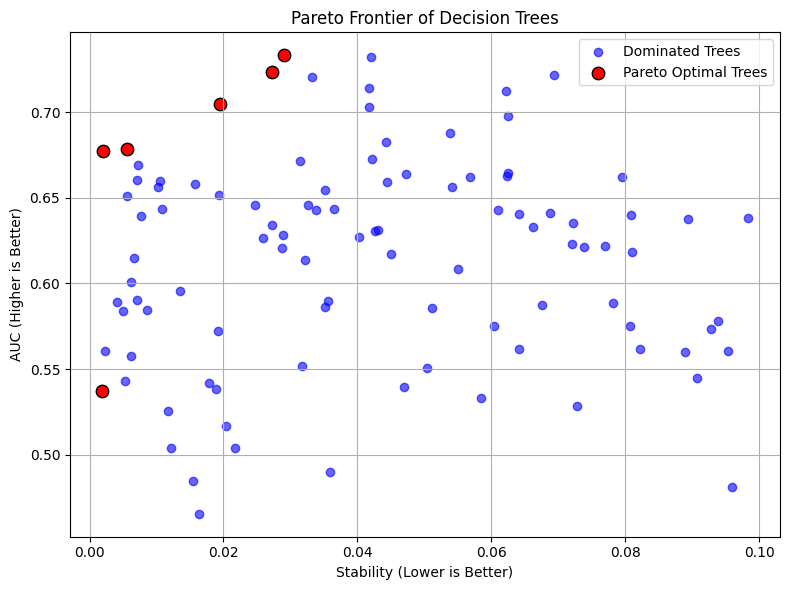

In [22]:
def plot_pareto_frontier(distances, auc_scores, pareto_indices):
    distances = np.array(distances)
    auc_scores = np.array(auc_scores)
    pareto_indices = set(pareto_indices)
    is_pareto = np.array([i in pareto_indices for i in range(len(distances))])
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(distances[~is_pareto], auc_scores[~is_pareto], c='blue', label='Dominated Trees', alpha=0.6)
    plt.scatter(distances[is_pareto], auc_scores[is_pareto], c='red', edgecolors='black', s=80, label='Pareto Optimal Trees')
    plt.xlabel("Stability (Lower is Better)")
    plt.ylabel("AUC (Higher is Better)")
    plt.title("Pareto Frontier of Decision Trees")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pareto_frontier(distances, auc_scores, pareto_trees)